In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, lfilter
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from tqdm import tqdm
from torch import optim

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [67]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    window_size, window_step = map(int, (window_size, window_step))
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((nw, ws), dtype=a.dtype)

    for i in range(nw):
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start: stop]

    return out


def normalisation(X):
    minX = np.min(X)
    maxX = np.max(X)

    return (X - minX)/(maxX - minX)


def stft(X, fftsize=128, step=65, mean_normalize=True, real=False,
         compute_onesided=True):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)

    size = fftsize
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X


def pretty_spectrogram(d, log=True, thresh=5, fft_size=512, step_size=64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(stft(d, fftsize=fft_size, step=step_size, real=False,
                           compute_onesided=True))

    if log == True:
        specgram /= specgram.max()  # volume normalize to max 1
        specgram = np.log10(specgram)  # take log
        specgram[specgram < -thresh] = -thresh  # set anything less than the threshold as the threshold
    else:
        specgram[specgram < thresh] = thresh  # set anything less than the threshold as the threshold

    return normalisation(specgram)

In [178]:
### Parameters ###
fft_size = 512 # window size for the FFT
step_size = fft_size/16 # distance to slide along the window (in time)
spec_thresh = 10 # threshold for spectrograms (lower filters out more noise)

class CustomDataset(Dataset):
    def __init__(self, clean_data, noisy_data):
        self.clean = clean_data
        self.noisy = noisy_data

    def __len__(self):
        return len(self.clean)

    def __getitem__(self, index):
        clean_spec = pretty_spectrogram(self.clean[index, :], fft_size=fft_size, step_size=step_size, log=True, thresh=spec_thresh).reshape(1, 256, 128)
        noisy_spec = pretty_spectrogram(self.clean[index, :], fft_size=fft_size, step_size=step_size, log=True, thresh=spec_thresh).reshape(1, 256, 128)

        clean_tensor = torch.from_numpy(clean_spec).to(torch.float32)
        noisy_tensor = torch.from_numpy(noisy_spec).to(torch.float32)
        return clean_tensor, noisy_tensor

In [179]:
class config:
    batch_size=10
    learning_rate=1e-3
    epochs=20

In [180]:
clean = pd.read_csv('label.csv').to_numpy()
noisy = pd.read_csv('train.csv').to_numpy()

test_clean = clean[:10]
test_noisy = noisy[:10]

training_dataset = CustomDataset(clean[10:900], noisy[10:900])
validation_dataset = CustomDataset(clean[900:], noisy[900:])

trainloader = DataLoader(training_dataset, batch_size=config.batch_size)
validloader = DataLoader(validation_dataset, batch_size=config.batch_size)

Text(0.5, 1.0, 'Original Spectrogram')

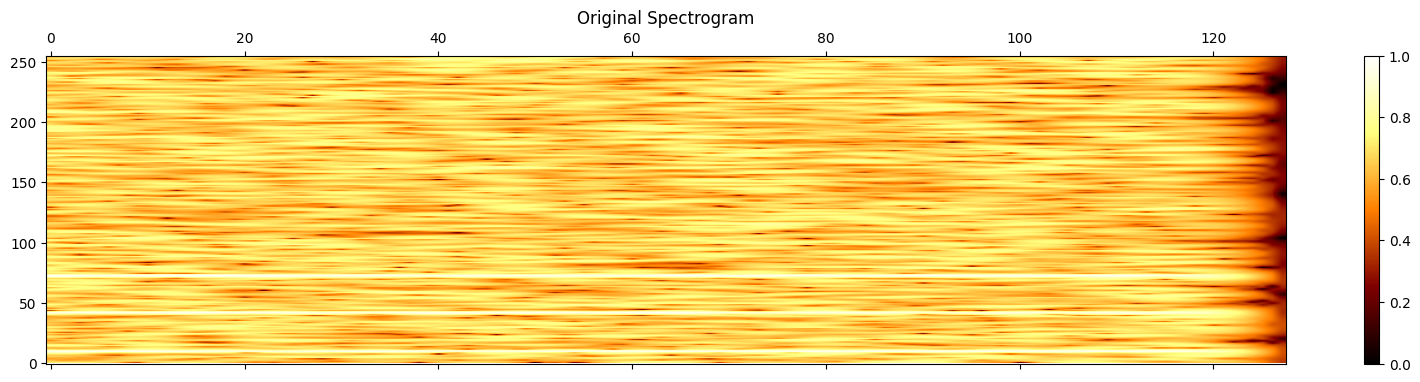

In [177]:
### Parameters ###
fft_size = 512 # window size for the FFT
step_size = fft_size/16 # distance to slide along the window (in time)
spec_thresh = 10 # threshold for spectrograms (lower filters out more noise)

s = test_noisy[0, :]

X = pretty_spectrogram(s.astype('float64'), fft_size = fft_size, step_size = step_size, log = True, thresh = spec_thresh)

X = normalisation(X)

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(X), interpolation='bilinear', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Original Spectrogram')

In [201]:
class autoencoders(nn.Module):
    def __init__(self):
        super(autoencoders, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 5, padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0),
            nn.Conv2d(32, 64, kernel_size = 5, padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0),
            nn.Conv2d(64, 128, kernel_size = 5, padding = "same"),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size = 5, stride = 2, output_padding=1, padding = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size = 5, stride = 2, output_padding=1, padding = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size = 5, stride = 2, output_padding=1, padding = 2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size = 5, stride = 1, padding = 2),
            nn.Sigmoid()
        )

    def forward(self, images):
        x = self.encoder(images)
        x = self.decoder(x)
        return x

In [202]:
model = autoencoders().to(device)

summary(model, (1, 256, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 128]             832
              ReLU-2         [-1, 32, 256, 128]               0
         MaxPool2d-3          [-1, 32, 128, 64]               0
            Conv2d-4          [-1, 64, 128, 64]          51,264
              ReLU-5          [-1, 64, 128, 64]               0
         MaxPool2d-6           [-1, 64, 64, 32]               0
            Conv2d-7          [-1, 128, 64, 32]         204,928
              ReLU-8          [-1, 128, 64, 32]               0
         MaxPool2d-9          [-1, 128, 32, 16]               0
  ConvTranspose2d-10          [-1, 128, 64, 32]         409,728
             ReLU-11          [-1, 128, 64, 32]               0
  ConvTranspose2d-12          [-1, 64, 128, 64]         204,864
             ReLU-13          [-1, 64, 128, 64]               0
  ConvTranspose2d-14         [-1, 32, 2

In [203]:
def trainA(dataloader, model, epoch, loss_fn, optimizer, device):
    model.train()
    total_loss = 0.0
    for i, (clean, noisy) in enumerate(tqdm(dataloader)):

        clean = clean.to(device)
        noisy = noisy.to(device)

        optimizer.zero_grad()
        pred = model(noisy)
        curr_loss = loss_fn(pred, clean)
        curr_loss.backward()
        optimizer.step()

        total_loss += curr_loss
        if i % 1000 == 0:
            print('[Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, total_loss / 200))
            total_loss = 0.0

def valA(dataloader, model, epoch, loss_fn, device):
    model.eval()
    total_loss = 0.0
    print('-------------------------')
    with torch.no_grad():
        for i, (clean, noisy) in enumerate(tqdm(dataloader)):
            clean = clean.to(device)
            noisy = noisy.to(device)

            output = model(noisy)
            loss = loss_fn(output, clean)
            total_loss += loss
            if i % 100 == 0:
                print('[Valid Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
                      (epoch + 1, i + 1, total_loss / 200))
                total_loss = 0.0

In [204]:
model = autoencoders().to(device)

optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
loss_fn = torch.nn.functional.mse_loss

for epoch in range(config.epochs):
    trainA(trainloader, model, epoch, loss_fn, optimizer, device)
    valA(validloader, model, epoch, loss_fn, device)

  6%|▌         | 5/89 [00:00<00:05, 16.34it/s]

[Epoch number : 1, Mini-batches:     1] loss: 0.061


100%|██████████| 89/89 [00:02<00:00, 31.35it/s]


-------------------------


 90%|█████████ | 9/10 [00:00<00:00, 40.54it/s]

[Valid Epoch number : 1, Mini-batches:     1] loss: 0.046


  4%|▍         | 4/89 [00:00<00:02, 31.72it/s]

[Epoch number : 2, Mini-batches:     1] loss: 0.046


100%|██████████| 89/89 [00:02<00:00, 33.91it/s]


-------------------------


 50%|█████     | 5/10 [00:00<00:00, 42.34it/s]

[Valid Epoch number : 2, Mini-batches:     1] loss: 0.046


  8%|▊         | 7/89 [00:00<00:02, 32.94it/s]

[Epoch number : 3, Mini-batches:     1] loss: 0.046


100%|██████████| 89/89 [00:02<00:00, 34.90it/s]


-------------------------


 50%|█████     | 5/10 [00:00<00:00, 40.95it/s]

[Valid Epoch number : 3, Mini-batches:     1] loss: 0.046


  4%|▍         | 4/89 [00:00<00:02, 32.49it/s]

[Epoch number : 4, Mini-batches:     1] loss: 0.046


100%|██████████| 89/89 [00:02<00:00, 36.09it/s]


-------------------------


 40%|████      | 4/10 [00:00<00:00, 39.57it/s]

[Valid Epoch number : 4, Mini-batches:     1] loss: 0.046


  4%|▍         | 4/89 [00:00<00:02, 31.72it/s]

[Epoch number : 5, Mini-batches:     1] loss: 0.046


100%|██████████| 89/89 [00:02<00:00, 33.90it/s]


-------------------------


 50%|█████     | 5/10 [00:00<00:00, 41.46it/s]

[Valid Epoch number : 5, Mini-batches:     1] loss: 0.046


  8%|▊         | 7/89 [00:00<00:02, 33.11it/s]

[Epoch number : 6, Mini-batches:     1] loss: 0.046


100%|██████████| 89/89 [00:02<00:00, 35.36it/s]


-------------------------


 50%|█████     | 5/10 [00:00<00:00, 42.16it/s]

[Valid Epoch number : 6, Mini-batches:     1] loss: 0.046


  4%|▍         | 4/89 [00:00<00:02, 31.72it/s]

[Epoch number : 7, Mini-batches:     1] loss: 0.046


100%|██████████| 89/89 [00:02<00:00, 35.71it/s]


-------------------------


 50%|█████     | 5/10 [00:00<00:00, 41.80it/s]

[Valid Epoch number : 7, Mini-batches:     1] loss: 0.046


  4%|▍         | 4/89 [00:00<00:02, 31.85it/s]

[Epoch number : 8, Mini-batches:     1] loss: 0.046


100%|██████████| 89/89 [00:02<00:00, 34.88it/s]


-------------------------


 50%|█████     | 5/10 [00:00<00:00, 41.46it/s]

[Valid Epoch number : 8, Mini-batches:     1] loss: 0.046


  4%|▍         | 4/89 [00:00<00:02, 31.97it/s]

[Epoch number : 9, Mini-batches:     1] loss: 0.046


100%|██████████| 89/89 [00:02<00:00, 34.62it/s]


-------------------------


 50%|█████     | 5/10 [00:00<00:00, 41.63it/s]

[Valid Epoch number : 9, Mini-batches:     1] loss: 0.046


  4%|▍         | 4/89 [00:00<00:02, 31.59it/s]

[Epoch number : 10, Mini-batches:     1] loss: 0.046


100%|██████████| 89/89 [00:02<00:00, 35.72it/s]


-------------------------


 50%|█████     | 5/10 [00:00<00:00, 40.95it/s]

[Valid Epoch number : 10, Mini-batches:     1] loss: 0.046


  8%|▊         | 7/89 [00:00<00:02, 31.61it/s]

[Epoch number : 11, Mini-batches:     1] loss: 0.046


100%|██████████| 89/89 [00:02<00:00, 35.32it/s]


-------------------------


 50%|█████     | 5/10 [00:00<00:00, 41.29it/s]

[Valid Epoch number : 11, Mini-batches:     1] loss: 0.046


  8%|▊         | 7/89 [00:00<00:02, 32.86it/s]

[Epoch number : 12, Mini-batches:     1] loss: 0.046


100%|██████████| 89/89 [00:02<00:00, 35.49it/s]


-------------------------


 50%|█████     | 5/10 [00:00<00:00, 43.44it/s]

[Valid Epoch number : 12, Mini-batches:     1] loss: 0.046


  4%|▍         | 4/89 [00:00<00:02, 32.10it/s]

[Epoch number : 13, Mini-batches:     1] loss: 0.046


100%|██████████| 89/89 [00:02<00:00, 38.39it/s]


-------------------------


 50%|█████     | 5/10 [00:00<00:00, 46.26it/s]

[Valid Epoch number : 13, Mini-batches:     1] loss: 0.046


  9%|▉         | 8/89 [00:00<00:02, 36.85it/s]

[Epoch number : 14, Mini-batches:     1] loss: 0.046


100%|██████████| 89/89 [00:02<00:00, 38.99it/s]


-------------------------


 50%|█████     | 5/10 [00:00<00:00, 44.80it/s]

[Valid Epoch number : 14, Mini-batches:     1] loss: 0.046


  4%|▍         | 4/89 [00:00<00:02, 34.75it/s]

[Epoch number : 15, Mini-batches:     1] loss: 0.046


100%|██████████| 89/89 [00:02<00:00, 39.11it/s]


-------------------------


 50%|█████     | 5/10 [00:00<00:00, 45.21it/s]

[Valid Epoch number : 15, Mini-batches:     1] loss: 0.046


  9%|▉         | 8/89 [00:00<00:02, 36.63it/s]

[Epoch number : 16, Mini-batches:     1] loss: 0.046


100%|██████████| 89/89 [00:02<00:00, 38.35it/s]


-------------------------


 50%|█████     | 5/10 [00:00<00:00, 43.82it/s]

[Valid Epoch number : 16, Mini-batches:     1] loss: 0.046


  4%|▍         | 4/89 [00:00<00:02, 34.75it/s]

[Epoch number : 17, Mini-batches:     1] loss: 0.046


100%|██████████| 89/89 [00:02<00:00, 38.08it/s]


-------------------------


 50%|█████     | 5/10 [00:00<00:00, 42.70it/s]

[Valid Epoch number : 17, Mini-batches:     1] loss: 0.046


  4%|▍         | 4/89 [00:00<00:02, 34.16it/s]

[Epoch number : 18, Mini-batches:     1] loss: 0.046


100%|██████████| 89/89 [00:02<00:00, 38.08it/s]


-------------------------


 50%|█████     | 5/10 [00:00<00:00, 45.62it/s]

[Valid Epoch number : 18, Mini-batches:     1] loss: 0.046


  9%|▉         | 8/89 [00:00<00:02, 36.54it/s]

[Epoch number : 19, Mini-batches:     1] loss: 0.046


100%|██████████| 89/89 [00:02<00:00, 38.36it/s]


-------------------------


 50%|█████     | 5/10 [00:00<00:00, 44.21it/s]

[Valid Epoch number : 19, Mini-batches:     1] loss: 0.046


  4%|▍         | 4/89 [00:00<00:02, 34.31it/s]

[Epoch number : 20, Mini-batches:     1] loss: 0.046


100%|██████████| 89/89 [00:02<00:00, 38.03it/s]


-------------------------


 50%|█████     | 5/10 [00:00<00:00, 45.62it/s]

[Valid Epoch number : 20, Mini-batches:     1] loss: 0.046


100%|██████████| 10/10 [00:00<00:00, 46.69it/s]


Text(0.5, 1.0, 'Original Spectrogram')

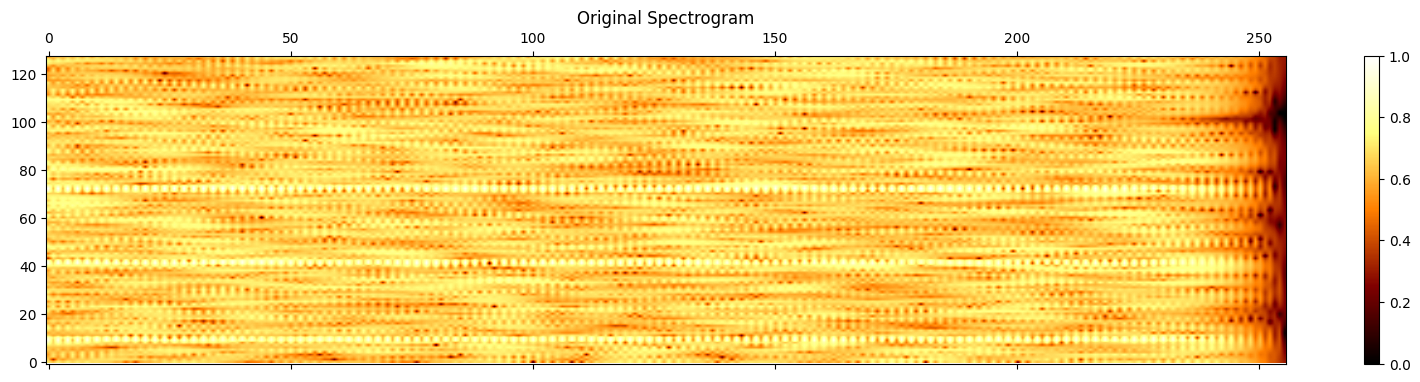

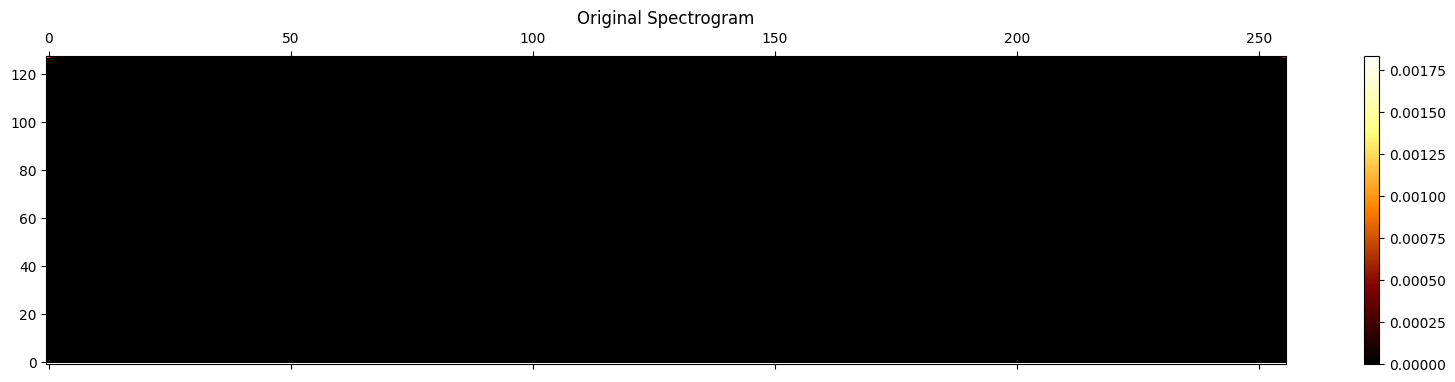

In [205]:
s = test_noisy[0, :]

X = pretty_spectrogram(s.astype('float32'), fft_size = fft_size, step_size = step_size, log = True, thresh = spec_thresh)

X = normalisation(X).reshape(1, 256, 128)

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(X), interpolation='bilinear', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Original Spectrogram')

res = model.forward(torch.from_numpy(X).to(torch.float32).to(device))

Xres = res.cpu().detach().numpy().reshape(256, 128)

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(Xres), interpolation='bilinear', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Original Spectrogram')
